In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
DEG2RAD = np.pi/180

In [3]:
from scipy.spatial.transform import Rotation as R

In [6]:
o1_planes = r'/mnt/BigSlowBoi/DOCUMENTS/Projects/AutomaticBoresightCalibration/Debug_INPUT/O1_Planes'
o2_planes = r'/mnt/BigSlowBoi/DOCUMENTS/Projects/AutomaticBoresightCalibration/Debug_INPUT/O2_Planes'
o3_planes = r'/mnt/BigSlowBoi/DOCUMENTS/Projects/AutomaticBoresightCalibration/Debug_INPUT/O3_Planes'
o4_planes = r'/mnt/BigSlowBoi/DOCUMENTS/Projects/AutomaticBoresightCalibration/Debug_INPUT/O4_Planes'
scenes = [o1_planes, o2_planes, o3_planes, o4_planes] 

In [7]:
def read_pcd(pcd_filename):
    with open(pcd_filename) as pcd_stream:
        point_dets = pcd_stream.readlines()
        
    points_only = point_dets[11:]
    ret_points = []
    for line in points_only:
        ret_points.append([float(f) for f in line.strip(r'\n').split(' ') if f != ''])
    
    return ret_points

In [8]:
# Get points on planes in all scenes
all_scene_planes = []
for scene in scenes:
    scene_planes = []
    for file in os.listdir(scene):
        if file.endswith(".pcd"):
            scene_planes.append(read_pcd(os.path.join(scene,file)))
    all_scene_planes.append(scene_planes)

In [9]:
# Get EOP for each plane in all scenes
scene_eops = []
eop_file = r'scene_details.txt'
with open(eop_file) as eop_stream:
    scene_eops_raw = eop_stream.readlines()

for eop in scene_eops_raw:
    scene_eops.append(np.array([float(f) for f in eop.strip(r'\n').split(' ') if f != '']))

In [10]:
boresight = np.array([-0.661, -0.272, -1.4158, 0, 0 , 90])

In [11]:
def move_to_ground(eop, boresight, n):
    t_eop = eop[:3]
    t_b = boresight[:3]
    R_eop = R.from_rotvec(DEG2RAD*eop[3:]).as_matrix()
    R_b = R.from_rotvec(DEG2RAD*boresight[3:]).as_matrix()
        
    n_g = t_eop + np.matmul(R_eop,t_b) + np.matmul(np.matmul(R_eop,R_b),n)
    
    return n_g

In [3]:
def make_pcd_header(n_pt):
    return(f'# .PCD v0.7 - Point Cloud Data file format\nVERSION 0.7\nFIELDS x y z\nSIZE 4 4 4\nTYPE F F F\nCOUNT 1 1 1\nWIDTH {n_pt}\nHEIGHT 1\nVIEWPOINT 0 0 0 2.98023e-07 1 0 -0\nPOINTS {n_pt}\nDATA ascii\n')

    

In [13]:
PCD_HEADER = '# .PCD v0.7 - Point Cloud Data file format\nVERSION 0.7\nFIELDS x y z\nSIZE 4 4 4\nTYPE F F F\nCOUNT 1 1 1\nWIDTH 632\nHEIGHT 1\nVIEWPOINT 0 0 0 2.98023e-07 1 0 -0\nPOINTS 632\nDATA ascii\n'

In [43]:
ground_points = []
for i in range(len(all_scene_planes)):
    scene_points = []
    for plane in all_scene_planes[i]: 
        plane_points = []
        for pt in plane:
            pt_ground = move_to_ground(scene_eops[i],boresight, pt)
            plane_points.append(pt_ground)
        scene_points.append(plane_points)
    ground_points.append(scene_points)

In [44]:
for i in range(len(ground_points)):
    for j in range(len(ground_points[i])):
        with open(f'Scene{i}_plane{j}_ground.pcd','w+') as pcd_file:
            pcd_file.write(make_pcd_header(len(ground_points[i][j])))
#             pcd_file.write(PCD_HEADER)
            for pnt in ground_points[i][j]:
                pcd_file.write(f'{pnt[0]} {pnt[1]} {pnt[2]}\n')

In [4]:
plane_file = r'PlaneEquations.txt'
eop_file = r'Orientation.txt'

plane_pcd = r'Cloud_Plane_0.pcd'

In [5]:
plane_details = []
with open(plane_file) as planes_stream:
    plane_details = planes_stream.readlines()


In [178]:
eop_details = []
with open(eop_file) as eop_stream:
    eop_raw = eop_stream.read()
eop = np.array([float(f) for f in eop_raw.strip(r'\n').split(' ') if f != ''])
eop[0] = eop[0] - (-1628660.0662500)
eop[1] = eop[1] - (-3658944.5390000)
eop[2] = eop[2] - (4948613.4167500)

SyntaxError: unexpected EOF while parsing (<ipython-input-38-fffe8d68c612>, line 1)

In [182]:
def comp_fit(points, plane):
    v_plane = np.array(plane[:3])
    residuals = []
    for point in points:
        v_point = np.array(point)
        res = v_point.dot(v_plane)
        residuals.append(res+plane[3])
#         print(res)
    return residuals

In [183]:
final_plane_details = []
for plane in plane_details:
#     print(plane.strip(r' \n').split(' '))
    plane = [float(f) for f in plane.strip(r'\n').split(' ') if f != '']
    final_plane_details.append(plane)

In [184]:
final_plane_details

[[0.798944, 0.598752, 0.0564357, -14.2932],
 [0.603087, -0.793938, -0.0771246, 15.7359],
 [0.605768, -0.78965, -0.0974536, -25.8559]]

In [185]:
pts = read_pcd(plane_pcd)

In [186]:
residuals  = comp_fit(pts, final_plane_details[0])

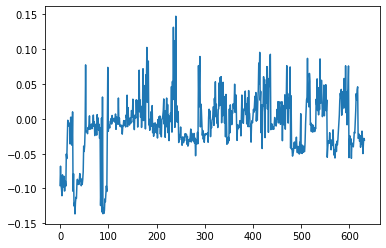

In [187]:
plt.plot(residuals)

# Rotate everything by Boresight Angles

In [227]:
boresight = np.array([-0.661, -0.272, -1.4158, 180, 0 , 90])

In [228]:
r = R.from_rotvec(DEG2RAD*boresight[3:6])

In [229]:
r.as_matrix()

array([[ 0.61359352,  0.16205898,  0.77281297],
       [-0.16205898, -0.93203242,  0.32411796],
       [ 0.77281297, -0.32411796, -0.54562594]])

In [230]:
rot_points = [r.apply(np.array(p)) for p in pts]
rot_plane = r.apply(np.array(final_plane_details[0][:3]))

In [231]:
res2 = comp_fit(rot_points, np.append(rot_plane, final_plane_details[0][3]))

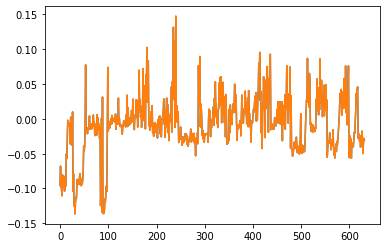

In [232]:
plt.figure()
plt.plot(residuals)
plt.plot(res2)

# Rotate and Translate

In [245]:
def move_to_ground(eop, boresight, n):
    t_eop = eop[:3]
    t_b = boresight[:3]
    R_eop = R.from_rotvec(DEG2RAD*eop[3:]).as_matrix()
    R_b = R.from_rotvec(DEG2RAD*boresight[3:]).as_matrix()
#     n_g = R_eop.apply(R_b.apply(n))
#     print(R_eop)
#     print(t_eop)
#     print(t_b)
#     print(R_eop)
#     print(R_b)
#     print(np.matmul(R_eop,t_b))
#     print(np.matmul(np.matmul(R_eop,R_b),n))
#     print(n)
    
    
    n_g = t_eop + np.matmul(R_eop,t_b) + np.matmul(np.matmul(R_eop,R_b),n)
    
    return n_g
    

In [246]:
def move_plane_to_ground(eop, boresight, n):
    t_eop = eop[:3]
    t_b = boresight[:3]
    R_eop = R.from_rotvec(DEG2RAD*eop[3:]).as_matrix()
    R_b = R.from_rotvec(DEG2RAD*boresight[3:]).as_matrix()
#     n_g = t_eop + R_eop.apply(t_b) + R_eop.apply(R_b.apply(n))

#     print(np.transpose(R_eop))
#     print(R_b)
    combined_r = np.transpose(np.linalg.inv(np.matmul(R_eop,R_b) ))
    n_g =  np.matmul(combined_r,n)
    
    return n_g

In [247]:
def find_plane_d(n, pts):
    dsum = 0
    for p in pts:
        dsum += np.dot(p,n)
    
    return -1*dsum/len(pts)

In [248]:
pts_g = [move_to_ground(eop, boresight, p) for p in pts]
plane_g = move_plane_to_ground(eop, boresight, final_plane_details[0][:3])
plane_g = np.append(plane_g, find_plane_d(plane_g, pts_g))

In [249]:
DEG2RAD*np.array([180,0,90])

array([3.14159265, 0.        , 1.57079633])

In [250]:
res3 = comp_fit(pts_g, plane_g)

In [256]:
np.mean(residuals)

-0.007588234887425685

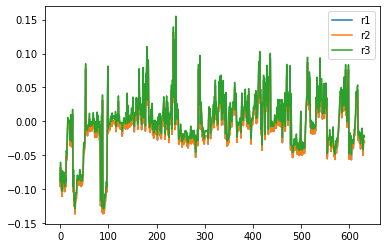

In [251]:
plt.figure()
plt.plot(residuals)
plt.plot(res2)
plt.plot(res3)
plt.legend(['r1','r2','r3'])

with open('points_ground.txt','w+') as write_file:
    for pt in pts_g:
        write_file.write(f'{pt[0]}, {pt[1]}, {pt[2]} \n')

In [240]:
pts[0]

[13.844746, 5.3113513, -0.77717853]

In [241]:
move_to_ground(eop,boresight,np.array(pts[0]))

[4.96925 0.756   2.10125]
[-0.661  -0.272  -1.4158]
[[ 0.79799486 -0.60211183 -0.02579809]
 [ 0.60167923  0.79840675 -0.02299487]
 [ 0.03444285  0.00282761  0.99940267]]
[[ 0.61359352  0.16205898  0.77281297]
 [-0.16205898 -0.93203242  0.32411796]
 [ 0.77281297 -0.32411796 -0.54562594]]
[-0.32717524 -0.58232047 -1.43849014]
[11.22731357 -0.89325203  9.67682705]
[13.844746    5.3113513  -0.77717853]


array([15.86938833, -0.7195725 , 10.33958691])

In [242]:
eop

array([ 4.96925   ,  0.756     ,  2.10125   ,  0.79400619, -1.85232734,
       37.01494077])

In [243]:
pts_g[0]

array([15.86938833, -0.7195725 , 10.33958691])

In [244]:
plane_g

array([  0.89626433,  -0.16376943,   0.41217749, -18.69086909])

In [257]:
pt_new_g = np.array([0.51649,14.4065,1.80133])

In [258]:
plane_new_g = np.array([-0.0023960022, 0.9996595567, -0.0259813357, 14.4417])

In [260]:
pt_new_g.dot(plane_new_g[:3]) + 14.4417

28.79525693298579

# Real misclosure plot

In [109]:
filename = r'w_output_original.txt'
filename_1m = r'w_output_iter.txt'

In [110]:
with open(filename) as w_instream:
    w = w_instream.readlines()
w[0].strip(r'\n').split(' ')
plot_w = []
for line in w:
    plot_w.append([float(f) for f in line.strip(r'\n').split(' ') if f != ''])
    
plot_w = np.array(plot_w)

In [111]:
w = []
with open(filename_1m) as w_instream:
    w2 = w_instream.readlines()
plot_w_1m = []
for line in w2:
    plot_w_1m.append([float(f) for f in line.strip(r'\n').split(' ') if f != ''])
    
plot_w_1m = np.array(plot_w_1m)

In [112]:
np.mean(plot_w)

-2.542691517909773

In [113]:
np.mean(plot_w_1m)

-19459.645681854774

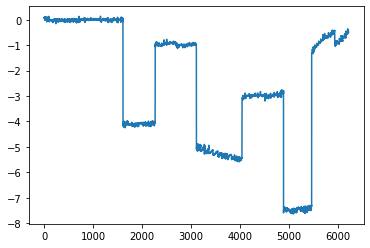

In [116]:
plt.figure()
plt.plot(plot_w)

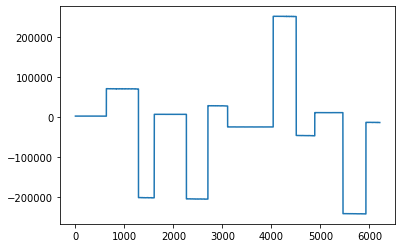

In [115]:

plt.plot(plot_w_1m)

In [96]:
plot_w_1m

array([[0.0881137],
       [0.0603706],
       [0.087369 ],
       ...,
       [1.08624  ],
       [1.06963  ],
       [1.00871  ]])

# Make PCD from C++ Output

In [4]:
output_file = r'/mnt/BigSlowBoi/DOCUMENTS/Projects/AutomaticBoresightCalibration/CalibrationAlgorithm/Project/FinalPoints_All.txt'
pts = []
with open(output_file) as pts_instream:
    pts = pts_instream.readlines()
pts[0].strip(r'\n').split(' ')
plot_pts = []
for line in pts:
    plot_pts.append([float(f) for f in line.strip(r'\n').split(' ') if f != ''])

In [5]:
with open(f'program_output.pcd','w+') as pcd_file:
            pcd_file.write(make_pcd_header(len(plot_pts)))
#             pcd_file.write(PCD_HEADER)
            for pnt in plot_pts:
                pcd_file.write(f'{pnt[0]} {pnt[1]} {pnt[2]}\n')

In [6]:
n1 = [-0.002396, 0.99966, -0.0259813,  -13.1004]
n2 = [-0.998212, 0.00126973, 0.0597669,  20.1988]
n3 = [-0.99676, 0.00536916, 0.0802591,  -21.3746]

In [23]:
# Fit for pl1
plane = n1
f_n1 = []
for pnt in plot_pts:
    f_n1.append(np.array(pnt).dot(np.array(plane)[:3])+plane[3])

In [18]:
# Fit for pl2
plane = n2
f_n2 = []
for pnt in plot_pts:
    f_n2.append(np.array(pnt).dot(np.array(plane)[:3])+plane[3])

In [19]:
# Fit for pl3
plane = n3
f_n3 = []
for pnt in plot_pts:
    f_n3.append(np.array(pnt).dot(np.array(plane)[:3])+plane[3])

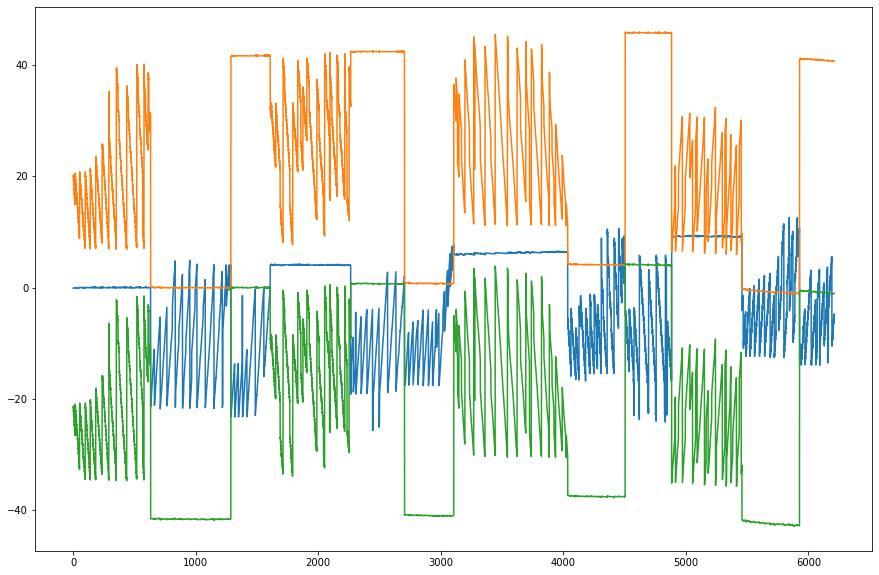

In [88]:
plt.figure(figsize=[15,10])
plt.plot(f_n1)
plt.plot(f_n2)
plt.plot(f_n3)

In [76]:
f_n2

[]